In [1]:
import pandas as pd
from pandas import *
import subprocess
import os
from datetime import date
from datetime import timedelta
import sys
from sklearn.linear_model import ElasticNet 
from collections import OrderedDict
from sklearn.neighbors.kde import KernelDensity
import brewer2mpl
import pylab as pl
import matplotlib as plt
import matplotlib
import matplotlib.pyplot as plt
# from mpltools import style
# from mpltools import special
import random
from rmsle import rmsle
import preprocessing as pp
import models as m
from sklearn.cross_validation import KFold

set_option('display.max_columns', 100)
plt.style.use('ggplot') 

%matplotlib inline

## Initial problem
* ### Objective: predict units sold given a date (and associated weather), store, and item number
* ### Units are weather-sensitive items
* ### Test set + training set is a 3 year span of sales for Walmart
    * Test set includes days within $\pm$ 3 days of a major storm, which we'll call "stormy days"
    * Test set includes only days within the final year (?)
    * Test set is not all stormy days in that time period
    * Training set is all remaining days
* ### Other issues
    * There are sime missing values in weather, indicated by 'M' (there are also "trace" amounts indicated by 'T'). These need to be filled oin
    * The test set and training set are fundamentally different. The training set includes many days not qualified as "stormy days" whereas the test set does not
    * There may be other trends, such as time
    * Item # is different by store
    
### Overview
* View datasets
* Analysis of missingness ('M' and 'T' values)
* Imputation
* Categorize stormy days
* Look at sales trends by store, item, date (dataviz)
* Inspect 0-sales days
* Build features
* Run models

## A logical first thing to do is to take a look at the features of the data we have to work with.

### Weather set

In [2]:
weather = read_csv('../data/weather.csv')
weather.head(2)

,station_nbr,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,sunrise,sunset,codesum,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed
0,1,2012-01-01,52,31,42,M,36,40,23,0,-,-,RA FZFG BR,M,0.05,29.78,29.92,3.6,20,4.6
1,2,2012-01-01,48,33,41,16,37,39,24,0,0716,1626,RA,0.0,0.07,28.82,29.91,9.1,23,11.3


### Training set

In [3]:
train = read_csv('../data/train.csv')
print train.shape
train.head(2)

(4617600, 4)


,date,store_nbr,item_nbr,units
0,2012-01-01,1,1,0
1,2012-01-01,1,2,0


### Test set

In [4]:
test = read_csv('../data/test.csv')
print test.shape
test.head(2)

(526917, 3)


,date,store_nbr,item_nbr
0,2013-04-01,2,1
1,2013-04-01,2,2


In [5]:
def fix_date(x):
    x = x.split('-')
    return date(int(x[0]), int(x[1]), int(x[2]))

for df in [weather, test, train]:
    df.loc[:, 'date'] = df.loc[:, 'date'].apply(lambda x: fix_date(x))

In [6]:
date(2014,10,26) - date(2012,1,1)

datetime.timedelta(1029)

In [7]:
month_days = {1: 0,
            2: 31,
            3: 59,
            4: 90,
            5: 120,
            6: 151,
            7: 181,
            8: 212,
            9: 243,
            10: 273,
            11: 303,
            12: 334}

def convert_date(x):
    year = x.year - 2012
    month = month_days[x.month]
    day = x.day
    
    if x < date(2012, 2, 29):
        return month + day
    else:
        return 1 + year*365 + month + day
    

train_dates = train.date.apply(lambda x: convert_date(x))

In [8]:
test_dates = test.date.apply(lambda x: convert_date(x))

### The test and training sets combine to make a full set of sales for 111 items in 45 stores spanning from 1/1/12 to 10/26/14. The test set includes only days after 4/1/13, within $\pm$ of a day they characterize as a storm.

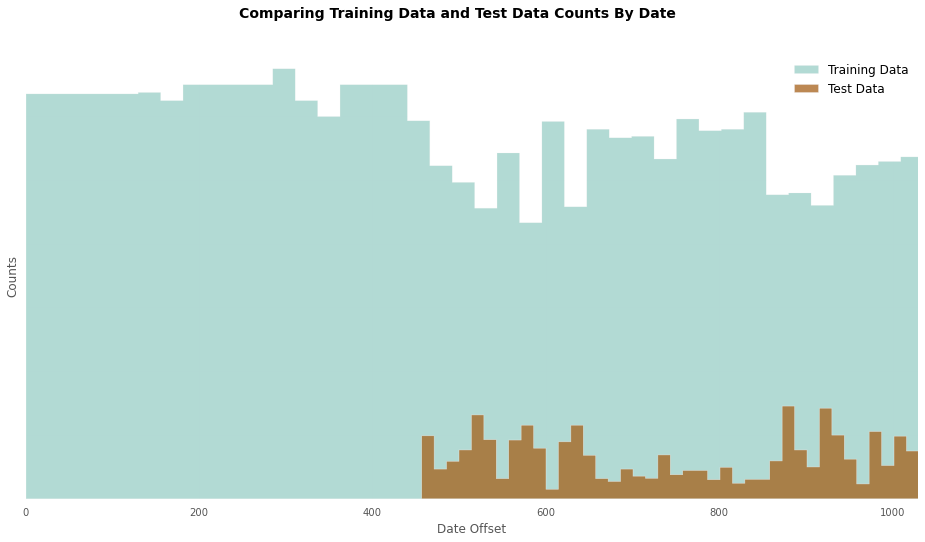

In [9]:
fig = plt.figure(figsize = (12,8)) 
ax = fig.add_subplot(1,1,1)
colors = brewer2mpl.get_map('BrBG','diverging',4).mpl_colors 

tr = plt.hist(train_dates, bins = 40, color = colors[3], normed = False, cumulative = False, 
     histtype = 'stepfilled', alpha = 0.30, label = 'Training Data')
te = plt.hist(test_dates, bins = 40, color = colors[0], normed = False, cumulative = False, 
     histtype = 'stepfilled', alpha = 0.75, label = 'Test Data')
for label in ax.get_xticklines():
    label.set_visible(False)
for label in ax.get_yticklines():
    label.set_visible(False)
for label in ax.get_yticklabels():
    label.set_visible(False)  
x = plt.xlim([0,1029])
plt.xlabel('Date Offset')
plt.ylabel('Counts')
ax.legend(loc = 'best')
plt.suptitle('Comparing Training Data and Test Data Counts By Date', 
             fontsize = 14, fontweight = 'bold')
plt.show()

### Key to join weather station with store

In [10]:
key = read_csv('../data/key.csv', index_col = 'store_nbr')
key.head(2)

,station_nbr
store_nbr,
1,1
2,14


### Sample submission - this is what the final output needs to look like

In [11]:
sample_submit = read_csv('../data/sampleSubmission.csv', index_col = 'id')
sample_submit.head(2)

,units
id,
2_1_2013-04-01,0
2_2_2013-04-01,0


### Initial prep of datasets
* Join key with test and trianing set
* Add store_item_date id to test set
* Convert dates to python dates

In [12]:
train = train.merge(key, left_on = 'store_nbr', right_index = True)
test = test.merge(key, left_on = 'store_nbr', right_index = True)

In [13]:
test.loc[:, 'id'] = test.store_nbr.apply(lambda x: str(x)) + '_' +\
                    test.item_nbr.apply(lambda x: str(x)) + '_' +\
                    test.date.apply(lambda x: str(x))

### Plot of station counts by store

In [14]:
station_counts = train[['station_nbr','store_nbr']].drop_duplicates().groupby('station_nbr').count()
station_counts = [station_counts.loc[c][0] if c in station_counts.index else 0 for c in np.arange(1,21,1)]

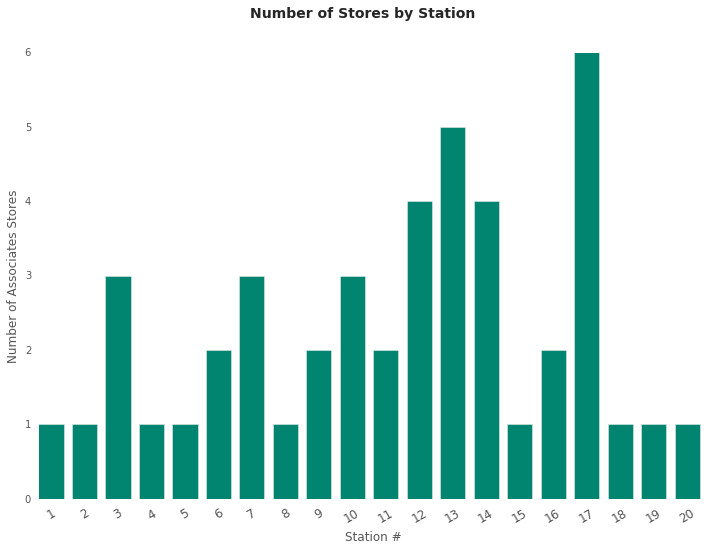

In [15]:
fig = plt.figure(figsize = (12,8))
ax = plt.subplot(111)

x = np.arange(1,21,1)
width = 0.75

colors = brewer2mpl.get_map('BrBG', 'diverging', 4).mpl_colors

bar = plt.bar(x, station_counts, width, color = colors[3])

for label in ax.get_xticklines():
    label.set_visible(False)

for label in ax.get_yticklines():
    label.set_visible(False)

plt.xticks(x+width/2,x, rotation = 30, fontsize = 12)
plt.xlabel('Station #')
plt.ylabel('Number of Associates Stores')
plt.suptitle('Number of Stores by Station', 
             fontsize = 14, fontweight = 'bold', color = '#262626')
x = plt.xlim([1, 21])
plt.show()


### Station 5 is not associated with any stores so we can throw it away

In [16]:
print test[['date','station_nbr']].groupby('station_nbr').count().index

Int64Index([1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], dtype='int64')


In [17]:
print train[['date','station_nbr']].groupby('station_nbr').count().index

Int64Index([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], dtype='int64')


In [18]:
train = train[train.station_nbr != 5]
weather = weather[weather.station_nbr != 5]

# Weather dataset

## There are 'T' values for trace, meaning small amount. We'll replace that with half the smallest non-zero value for that column.
* ### First call unix tools to see which columns have 'T' values.

In [19]:
pwd = os.getcwd()

trace = {}
for i, col in enumerate(weather.columns):
    cmd = "cut -d, -f" + str(i+1) + " ../data/weather.csv | grep 'T' | wc -l"
    ps = subprocess.Popen(cmd,shell=True,stdout=subprocess.PIPE,stderr=subprocess.STDOUT)
    output = ps.communicate()[0].replace('\n','')

    trace[col] = float("{:.2f}".format(float(output) / len(weather)))
    
trace = DataFrame.from_dict(trace, orient = 'index')
trace.columns = ['Proportion Trace']
trace[trace['Proportion Trace'] > 0]

,Proportion Trace
snowfall,0.02
preciptotal,0.12
codesum,0.10


### Codesum T is just a code (not trace). Get minimum for snowfall and preciptotal and replace 'T' with half that value.

In [20]:
for col in ['snowfall','preciptotal']:
    # temporarily replace with -1
    v = weather.loc[:, col].apply(lambda x: -1. if str(x).strip() in ['M', 'T'] else float(x))
    # replace 'T' with the minimum non-zero value
    weather.loc[:, col] = weather.loc[:, col].apply(lambda x: v[v > 0].min() if str(x).strip() == 'T' else x)

In [21]:
print len(weather[weather.snowfall == 'T'])
print len(weather[weather.preciptotal == 'T'])

0
0


## We can use the subprocess library to run unix commands to count the number of missing values (denoted by 'M') in the dataset.

In [23]:
pwd = os.getcwd()

missing = {}
for i, col in enumerate(weather.columns):
    cmd = "cut -d, -f" + str(i+1) + " ../data/weather.csv | grep 'M' | wc -l"
    ps = subprocess.Popen(cmd,shell=True,stdout=subprocess.PIPE,stderr=subprocess.STDOUT)
    output = ps.communicate()[0].replace('\n','')

    missing[col] = float("{:.2f}".format(float(output) / len(weather)))
    
missing = DataFrame.from_dict(missing, orient = 'index')
missing.columns = ['Proportion Missing']

* #### Departure is missing 56% of values. This may be unusable but if we can get data from surrounding days we can recover a lot of the average temperatures.
* #### Snowfall is missing 35% of values. This could be a key column so we should take more care in imputing it.
* #### The others are missing 8% or fewer.

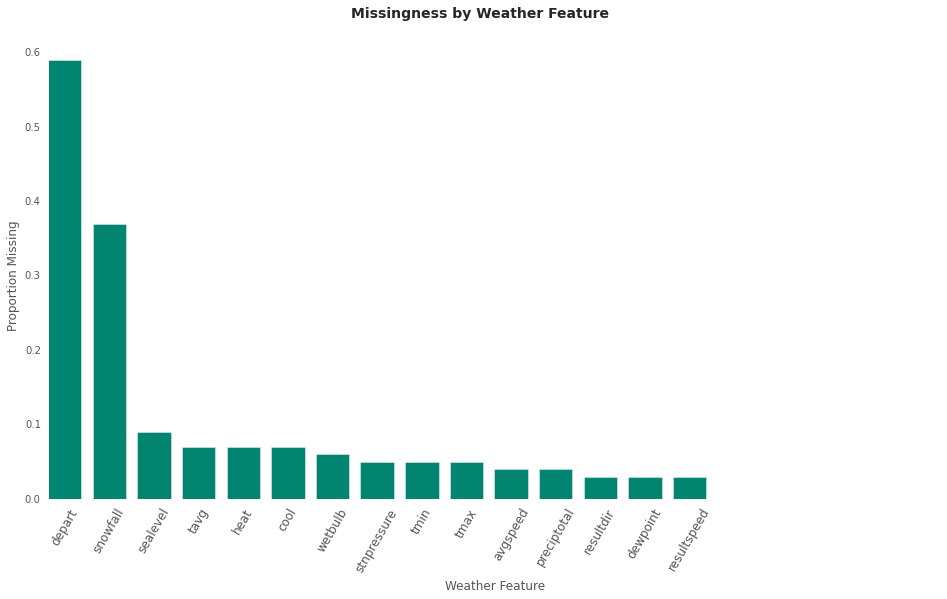

In [24]:
mm = missing[missing['Proportion Missing'] > 0].sort('Proportion Missing', ascending = False)

fig = plt.figure(figsize = (12,8))
ax = plt.subplot(111)

x = np.arange(1,len(mm.index)+1,1)
width = 0.75

colors = brewer2mpl.get_map('BrBG', 'diverging', 4).mpl_colors

bar = plt.bar(x, mm.iloc[:, 0], width, color = colors[3])

for label in ax.get_xticklines():
    label.set_visible(False)

for label in ax.get_yticklines():
    label.set_visible(False)

plt.xticks(x+width/2,mm.index, rotation = 60, fontsize = 12)
plt.xlabel('Weather Feature')
plt.ylabel('Proportion Missing')
plt.suptitle('Missingness by Weather Feature', 
             fontsize = 14, fontweight = 'bold', color = '#262626')
x = plt.xlim([1, 21])
plt.show()

Below is a list of columns to impute (excluding departure and snowfall).

In [25]:
icols = ['station_nbr']
icols.extend(list(missing[missing['Proportion Missing'] > 0].index.drop(['depart','snowfall'])))
print icols

['station_nbr', 'tavg', 'resultdir', 'stnpressure', 'tmin', 'wetbulb', 'dewpoint', 'avgspeed', 'tmax', 'sealevel', 'heat', 'preciptotal', 'resultspeed', 'cool']


In [26]:
heatcols = ['station_nbr']
heatcols.extend(list(missing[missing['Proportion Missing'] > 0].index))

### We can now look at which values are missing for each station to find any patterns in the missing data.

A good way to visualize this is with a heatmap.

In [27]:
def heat_vals(weather):
    mreplace = weather.copy()
    for c in heatcols:
        mreplace.loc[:, c] = mreplace.loc[:, c].apply(lambda x: float('nan') if x == 'M' else float(x))
        
    station_missing = mreplace.groupby('station_nbr').count()
    
    scounts = weather[['station_nbr','date']].groupby('station_nbr').count()
    scounts.columns = ['total']
    station_missing = station_missing.merge(scounts, left_index = True, right_index = True)
    station_missing = station_missing.drop('date', 1)
    for c in station_missing.columns:
        station_missing.loc[:, c]  = (1 - station_missing.loc[:, c] / station_missing.loc[:, 'total']).apply(lambda x: float(x))
    station_missing = station_missing.drop('total', 1)

    # get row/column names
    column_labels = list(OrderedDict.fromkeys([int(i[0]) for i in station_missing.stack().index]))
    row_labels = list(OrderedDict.fromkeys([i[1] for i in station_missing.stack().index]))

    return column_labels, row_labels, station_missing.values

In [28]:
def heatmap((column_labels, row_labels, heat), beforeafter = 'Before'):
    fig = plt.figure(figsize = (16,12))
    ax = plt.subplot(111)

    heatmap = ax.pcolor(heat, cmap=plt.cm.Blues)

    ax.set_xticks(np.arange(heat.shape[0])+0.5, minor=False)
    ax.set_yticks(np.arange(heat.shape[1])+0.5, minor=False)

    # want a more natural, table-like display
    ax.invert_yaxis()
    ax.xaxis.tick_top()

    ax.set_xticklabels(row_labels, minor=False, rotation = 60)
    ax.set_yticklabels(column_labels, minor=False)

    plt.xlim([0,len(row_labels)])

    for label in ax.get_yticklines():
        label.set_visible(False)
    plt.xlabel('Feature')
    plt.ylabel('Station Number')

    plt.colorbar(heatmap, label = 'Proportion Missing')

    plt.suptitle('Data Missingness by Store and Weather Feature (' + beforeafter + ')', 
                 fontsize = 14, fontweight = 'bold')
    plt.show()

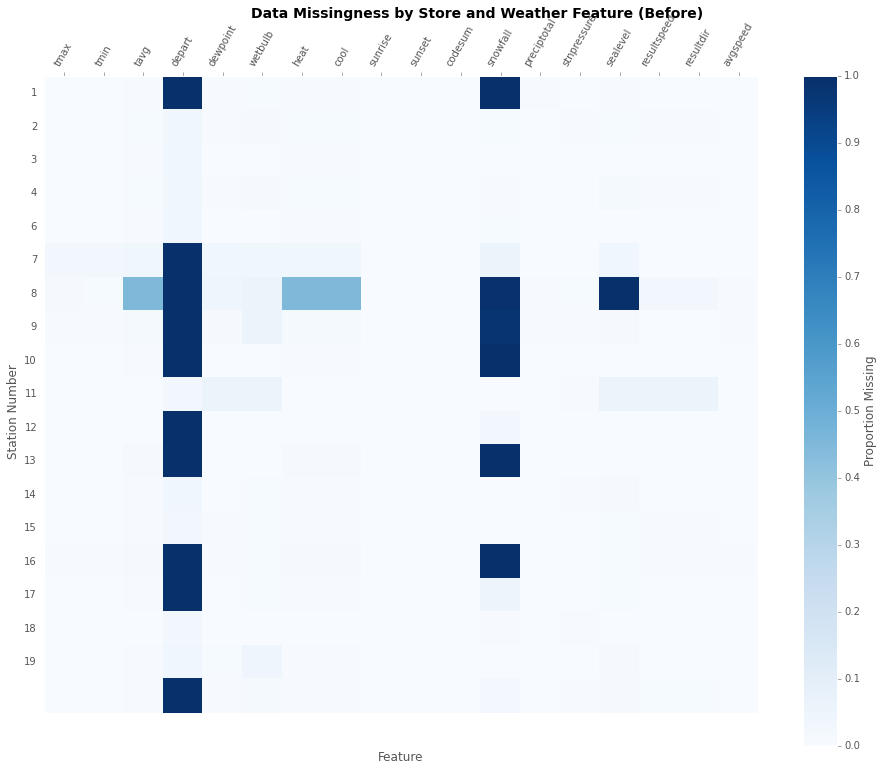

In [29]:
heatmap(heat_vals(weather))

### We will use the following steps to impute as many missing values as possible. Each step fills in some missing values, but others remain missing. For those still missing, we loosen the restrictions. Since snowfall and preciptotal are missing so many values (35% and 56%, respectively), we'll look at those separately later.
* Calculate the average value for that measure within a $\pm$ 3 day window.
* Calculate the average value for that measure within a $\pm$ 5 day window.
* Calculate the average value for that measure within a $\pm$ 15 day window.
* If that still fails, replace the value with the store average for that month and day of week for all years.

In [30]:
for c in [c for c in icols if c != 'store_nbr']:
    weather.loc[:, c] = weather.loc[:, c].apply(lambda x: float('nan') if x == 'M' else float(x))

In [31]:
# pm_weather takes a row from a df, a dict w
# and number of days offset, and adds a row to d
# for each date and corresponding values from the 
# df row
# ultimately, this lets us average the values
# from a window around a target day

def pm_weather(row, w, d, icols):
    # current date
    currdate = row.date
    
    # all values for the columns we want
    vals = list(row.loc[icols].values)
    
    n = len(w)
    # make a row for +/- 3 days from this current date/station
    for day in range(-d, d+1):
        w[day + n + d] = [currdate + timedelta(days = day)]
        w[day + n + d].extend(vals)
    
    return w

In [32]:
# make a df of all +/- 3 day windows
def impute_vals(weather, window):
    wimpute = {}

    for i in weather.index:
        wimpute = pm_weather(weather.loc[i, :], wimpute, 3, icols)

    impute = DataFrame.from_dict(wimpute, orient = 'index')
    wcols = ['date']
    wcols.extend(icols)
    impute.columns = wcols
    
    station_date_means = impute.groupby(['date','station_nbr']).mean()
    # for each column to impute
    for col in list(missing[missing['Proportion Missing'] > 0].index.drop(['depart','snowfall'])):
        # for each cell
        for i in weather.index:
            # if it's M replace with the station_date_mean value
            if np.isnan(weather.loc[i, col]):
                idx = (weather.loc[i, 'date'], weather.loc[i, 'station_nbr'])
                weather.loc[i, col] = station_date_means.loc[idx, col]
    
    return weather, wcols

In [33]:
weather, wcols = impute_vals(weather, 3)
weather, wcols = impute_vals(weather, 5)
weather, wcols = impute_vals(weather, 15)

In [34]:
stationmonth = weather.loc[:, wcols]
stationmonth.loc[:, 'date'] = stationmonth.date.apply(lambda x: (x.month, x.weekday()))
stationmonth = stationmonth.groupby(['date','station_nbr']).mean()

In [35]:
for col in list(missing[missing['Proportion Missing'] > 0].index.drop(['depart','snowfall'])):
    # for each cell
    for i in weather.index:
        # if it's M replace with the station_date_mean value
        if np.isnan(weather.loc[i, col]):
            idx = (
                    (\
                     weather.loc[i, 'date'].month, \
                     weather.loc[i, 'date'].weekday() \
                    ), \
                     weather.loc[i, 'station_nbr'])
            try:
                weather.loc[i, col] = stationmonth.loc[idx, col]
            except:
                pass

### In some cases, we have max temperature and min temperature but not the average temperature. We can use regularized linear regression to find the most likely average temperature, given a minimum and maximum.

In [36]:
tavg = read_csv('../data/weather.csv')[['tmin','tmax','tavg']]
for c in tavg.columns:
    tavg.loc[:, c] = tavg.loc[:, c].apply(lambda x: float('nan') if x == 'M' or x == float('inf') else float(x))
tavg = tavg.dropna()

In [37]:
en = ElasticNet()
en.fit(tavg[['tmin','tmax']].values, tavg[['tavg']].values)

ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [38]:
imputable = weather.loc[:, ['tmin','tmax']].dropna().index.values

In [39]:
for w in weather.loc[imputable, ].index:
    if np.isnan(weather.loc[w, 'tavg']):
        weather.loc[w, 'tavg'] = en.predict(weather.loc[w, ['tmin','tmax']])[0]

## Next, we look for a pattern in the missing preciptotal and snowfall values.

### First, we take a look at the missingness by date. There are some spikes but not apparent trend.

In [40]:
def missingness_plot(feat):
    temp = weather[weather[feat] == 'M'][['date', feat]]
    missing_dates = temp.date.apply(lambda x: convert_date(x)).values
    
    fig = plt.figure(figsize = (10,6))
    ax = plt.subplot(111)
    plt.suptitle('Kernel Density Estimate for ' + feat + ' Missingness over Time',
                 fontweight = 'bold', color = '#262626', fontsize = 16)

    missing_dates = missing_dates.reshape(-1, 1)

    kde = KernelDensity(bandwidth=2).fit(missing_dates)
    x = np.linspace(missing_dates.min(), missing_dates.max(), 100).reshape(-1, 1)
    density = np.exp(kde.score_samples(x))

    plt.plot(x, density, linewidth = 5, label = 'Missingness Density', color = colors[0])
    plt.plot(missing_dates, abs(np.random.rand(len(missing_dates), 1)/20000), 'ok', \
             ms=10, alpha=.03, color = colors[3], label = 'Jittered Data Points')
    plt.vlines((test.date.min() - train.date.min()).days, 0, max(density), \
               linestyles = '--', label = 'Training Set Start')

    plt.xlim([0, 1029])

    plt.xlabel('Date Offset')
    plt.ylabel("Density")

    xaxis = [temp.date.min() + timedelta(days = i) for i in np.arange(0,1030,45)]
    xvals = np.arange(0,1030,45)
    plt.xticks(xvals, xaxis, rotation = 60, fontsize = 10)

    for label in ax.get_xticklines():
        label.set_visible(False)
    for label2 in ax.get_yticklines():
        label2.set_visible(False)

    ax.legend(loc = 'best')

    plt.show()

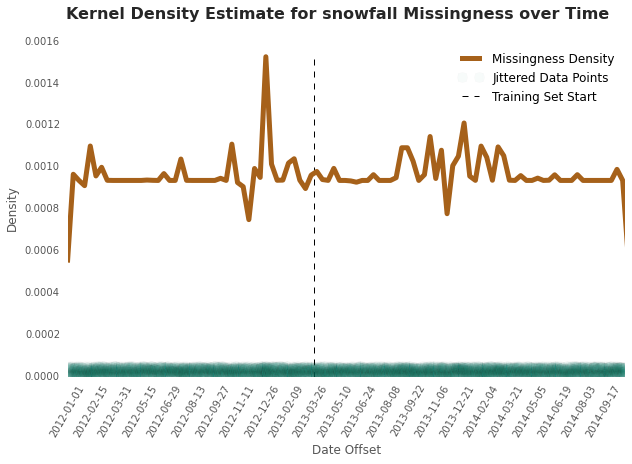

In [41]:
missingness_plot('snowfall')

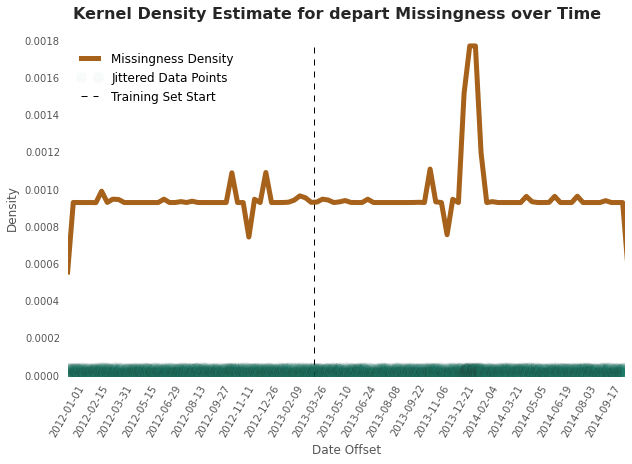

In [42]:
missingness_plot('depart')

### With date providing no clues for a missing data pattern, we turn to the weather stations.

In [43]:
stationcounts = weather[['station_nbr','date']].groupby('station_nbr').count()
stationcounts.columns = ['total']
for wtype in ['snowfall','depart']:
    stations = weather[weather[wtype] == 'M'][['station_nbr','depart']].groupby('station_nbr').count()
    temp = weather[weather[wtype] == 'M'][['station_nbr','depart']]
    if wtype == 'snowfall':
        stationcounts['snow'] = temp.station_nbr.apply(lambda x: x).value_counts()
    else:
        stationcounts['depart'] = temp.station_nbr.apply(lambda x: x).value_counts()
stationcounts.loc[:, 'snow'] = stationcounts.loc[:, 'snow'].apply(lambda x: float(x)) / stationcounts.total
stationcounts.loc[:, 'depart'] = stationcounts.loc[:, 'depart'].apply(lambda x: float(x)) / stationcounts.total        

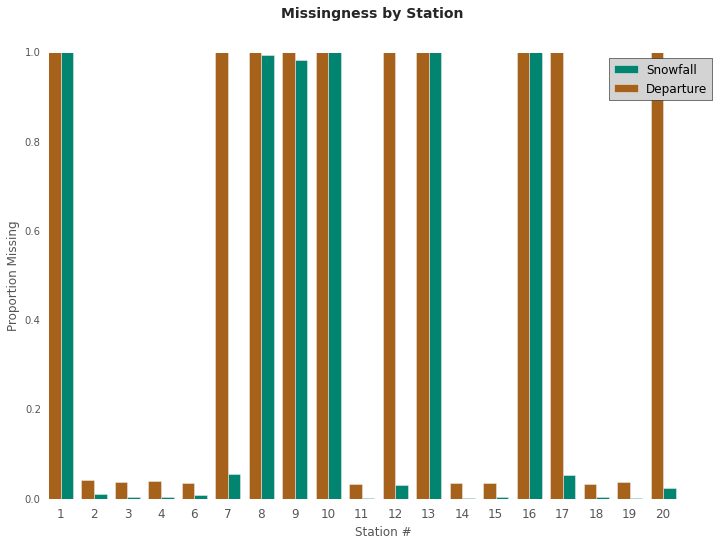

In [44]:
fig = plt.figure(figsize = (12, 8))
ax = plt.subplot(111)

# x = np.arange(1,len(m.index)+1,1)
x = np.arange(1,len(stationcounts.index)+1,1)
width = 0.75

colors = brewer2mpl.get_map('BrBG', 'diverging', 4).mpl_colors

bar = plt.bar(x+width/2, stationcounts.iloc[:, 1], width/2, color = colors[3], label = 'Snowfall')
bar2 = plt.bar(x, stationcounts.iloc[:, 2], width/2, color = colors[0], label = 'Departure')

for label in ax.get_xticklines():
    label.set_visible(False)

for label in ax.get_yticklines():
    label.set_visible(False)

plt.xticks(x+width/2,[int(i) for i in stationcounts.index], fontsize = 12)
plt.xlabel('Station #')
plt.ylabel('Proportion Missing')
plt.suptitle('Missingness by Station', 
             fontsize = 14, fontweight = 'bold', color = '#262626')
x = plt.xlim([1, 21])

legend = ax.legend(loc = 'best')
legend = plt.legend(frameon = 2)
frame = legend.get_frame()
frame.set_color('lightgray')
frame.set_edgecolor('black') 

plt.show()

### This bar chart above shows an obvious pattern in the missing data values. Certain stations either do not ever or rarely report snowfall or preciptotal.

The table below shows those stations with near 100% missingness. There is no reasonable way we can think of to impute these values.

In [45]:
stationcounts[np.logical_and(stationcounts.snow > 0.75, stationcounts.depart > 0.5)]

,total,snow,depart
station_nbr,,,
1,1035,1.000000,1
8,1035,0.995169,1
9,1035,0.982609,1
10,1035,1.000000,1
13,1035,1.000000,1
16,1035,1.000000,1


In [46]:
no_snow_depart = list(stationcounts[np.logical_and(stationcounts.snow > 0.75, stationcounts.depart > 0.5)].index)
no_snow_depart

[1.0, 8.0, 9.0, 10.0, 13.0, 16.0]

### We can apply the same methods we used for imputing the other values: use an increasingly wide window to use recent weather patterns for that station to fill in the missing values.

For departure, we feel it makes more sense to first calculate the historic average ($tavg - depart$) and then impute that historic average temperature. We then replace the historic average temperature with the departure at the end.

In [47]:
for c in [c for c in ['snowfall','depart'] if c != 'store_nbr']:
    weather.loc[:, c] = weather.loc[:, c].apply(lambda x: float('nan') if x == 'M' else float(x))
weather.loc[:, 'depart'] = weather.tavg - weather.depart

In [48]:
# make a df of all +/- 3, 5, 15 day windows
for numdays in [3, 5, 15]:
    wimpute = {}
    for i in weather.index:
#         if weather.loc[i, 'station_nbr'] not in no_snow_depart:
        wimpute = pm_weather(weather.loc[i, :], wimpute, numdays, ['station_nbr','snowfall','depart'])

    impute = DataFrame.from_dict(wimpute, orient = 'index')
    wcols = ['date']
    wcols.extend(['station_nbr','snowfall','depart'])
    impute.columns = wcols
    impute.head(2)
    station_date_means = impute.groupby(['date','station_nbr']).mean()
    station_date_means.head(2)

    # for each column to impute
    for col in ['depart','snowfall']:
        # for each cell
        for i in weather.index:
            # if it's M replace with the station_date_mean value
            if np.isnan(weather.loc[i, col]): #and \
                    #weather.loc[i, 'station_nbr'] not in no_snow_depart:
                idx = (weather.loc[i, 'date'], weather.loc[i, 'station_nbr'])
                weather.loc[i, col] = station_date_means.loc[idx, col]

In [49]:
storemonth = weather.loc[:, ['station_nbr','snowfall','depart','date']]
storemonth.loc[:, 'date'] = storemonth.loc[:, 'date'].apply(lambda x: (x.month, x.weekday()))
storemonth = storemonth.groupby(['date','station_nbr']).mean()

for col in ['snowfall','depart']:
    # for each cell
    for i in weather.index:
        # if it's M replace with the station_date_mean value
        if np.isnan(weather.loc[i, col]):
            idx = (
                    (\
                     weather.loc[i, 'date'].month, \
                     weather.loc[i, 'date'].weekday() \
                    ), \
                     weather.loc[i, 'station_nbr'])
            try:
                weather.loc[i, col] = storemonth.loc[idx, col]
            except:
                pass

### For an initial handling of snowfall, we can see in the table below that we can predict 0 snow when the temperature is over the freezing point.

In [50]:
for tmin in np.arange(20, 40, 2):
    print tmin, weather[weather.tmin > tmin].snowfall.apply(lambda x: float('nan') if x == 'M' else float(x)).dropna().mean()

20 0.0227544712976
22 0.0178022655467
24 0.015187243926
26 0.0122026232474
28 0.00752495499918
30 0.00405365210315
32 0.00119914098323
34 0.000281008625612
36 0.000174890402015
38 0.000157369746272


In [51]:
for i in weather.index:
    if weather.loc[i, 'snowfall'] == 'M' and weather.loc[i, 'tmin'] > 32:
        weather.loc[i, 'snowfall'] = 0

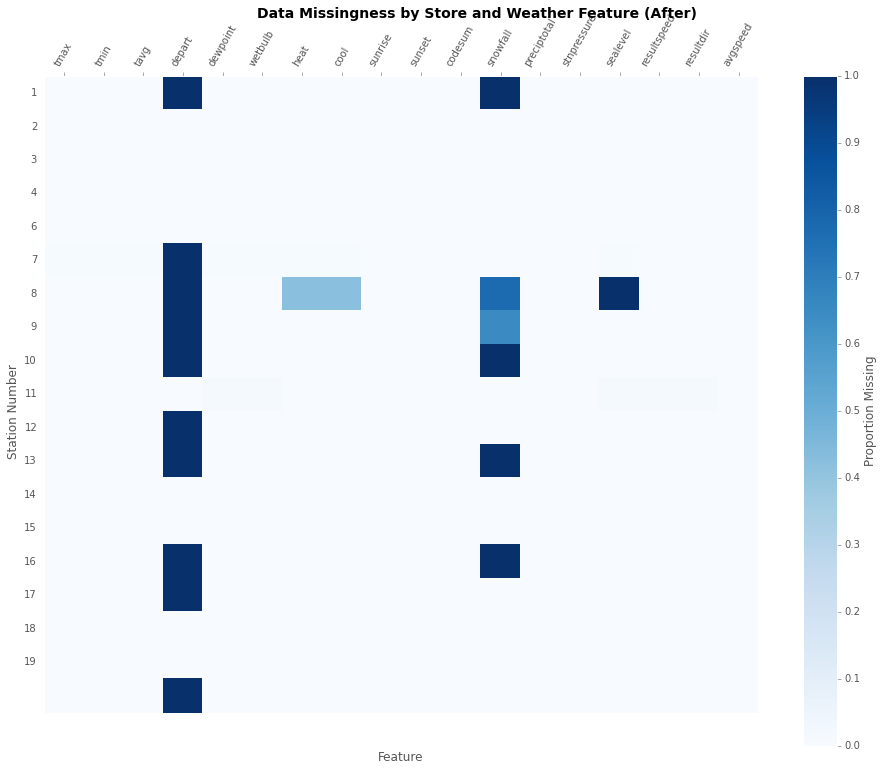

In [52]:
heatmap(heat_vals(weather), 'After')

Now, as mentioned above, we replace the departure back with average minus historical.

In [53]:
weather.loc[:, 'depart'] = weather.tavg - weather.depart

# The next step is to find days with proximity ($\pm$ 3 days) to stormy days, using Walmart's definition of a storm.

In [54]:
weather.loc[:, 'snow_codes'] = weather.codesum.apply(lambda x: 1 if 'SN' in x or 'SG' in x else 0)
weather.loc[:, 'rain_codes'] = weather.codesum.apply(lambda x: 1 if 'SN' not in x and 'RA' in x else 0)
snowdays = list(weather[np.logical_and(np.logical_and(weather.snow_codes == 1, weather.snowfall >= 2), \
                                       np.isnan(weather.snowfall) == False)].index)
raindays = list(weather[np.logical_and(np.logical_and(weather.rain_codes == 1, weather.preciptotal >= 1), \
                                       np.isnan(weather.preciptotal) == False)].index)

stormydays = snowdays
stormydays.extend(raindays)
stormydays = list(set(stormydays))

weather.loc[stormydays, 'extreme'] = 1

weather_events = {}

for w in weather[weather.extreme == 1].index:
    station = weather.loc[w, 'station_nbr']
    for i in [i for i in range(-3, 4) if i != 0]:
        curr_date = weather.loc[w, 'date'] + timedelta(days = i)
        
        if i not in weather_events:
            weather_events[i] = []
        
        weather_events[i].append(str(station) + '_' + str(curr_date))

weather.loc[:, 'extreme'] = weather.loc[:, 'extreme'].apply(lambda x: 0 if np.isnan(x) else 1)
weather['store_date'] = weather.station_nbr.apply(lambda x: str(x)) + '_' + weather.date.apply(lambda x: str(x))
for i in [i for i in range(-3, 4) if i != 0]:
    weather.loc[:, 'ext_' + str(i)] = weather.store_date.apply(lambda x: 1 if x in weather_events[i] else 0)
weather = weather.drop('store_date', 1)

weather['all_extreme'] = weather[['extreme','ext_-3','ext_-2','ext_-1','ext_1','ext_2','ext_3']].sum(axis = 1)

In [55]:
prox = weather[['date','station_nbr','ext_-3','ext_-2','ext_-1','extreme','ext_1','ext_2','ext_3']]

### The plots below gives us a high level look at the distribution of storms over time. The first plot shows all days in the datasets, and the second plot shows the number of storms aggregated by month.

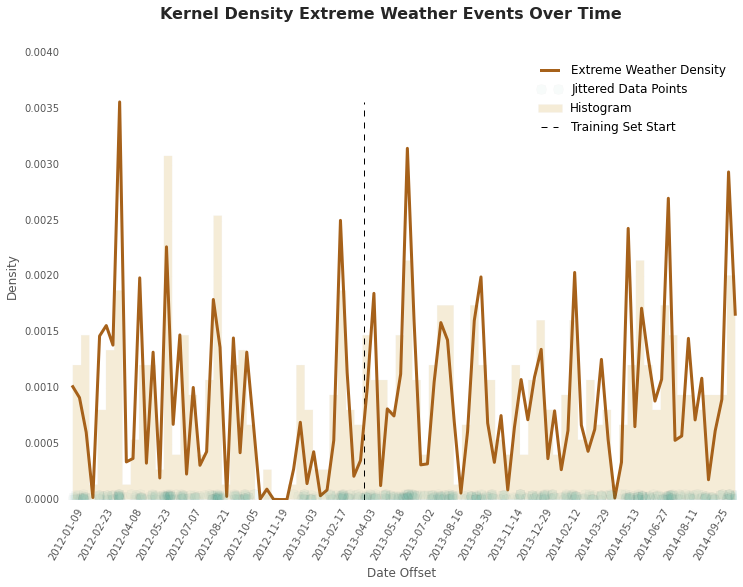

In [56]:
daily_ext = prox[prox.extreme == 1][['date','extreme']]
dates_ext = daily_ext.date.apply(lambda x: convert_date(x)).values
# daily_ext = daily_ext.drop('idx', 1)

fig = plt.figure(figsize = (12,8))
ax = plt.subplot(111)
plt.suptitle('Kernel Density Extreme Weather Events Over Time',
             fontweight = 'bold', color = '#262626', fontsize = 16)

dates_ext = dates_ext.reshape(-1, 1)

kde = KernelDensity(bandwidth=2).fit(dates_ext)
x = np.linspace(dates_ext.min(), dates_ext.max(), 100).reshape(-1, 1)
density = np.exp(kde.score_samples(x))

plt.plot(x, density, linewidth = 3, label = 'Extreme Weather Density', color = colors[0])
plt.plot(dates_ext, abs(np.random.rand(len(dates_ext), 1)/20000), 'ok', \
         ms=10, alpha=.03, color = colors[3], label = 'Jittered Data Points')
plt.vlines((test.date.min() - train.date.min()).days, 0, max(density), linestyles = '--', label = 'Training Set Start')
plt.hist(dates_ext, bins = 80, color = colors[1], normed = True, cumulative = False, 
     histtype = 'stepfilled', alpha = 0.30, label = 'Histogram')

plt.xlim([0, 1029])

plt.xlabel('Date Offset')
plt.ylabel("Density")

xaxis = [daily_ext.date.min() + timedelta(days = i) for i in np.arange(0,1030,45)]
xvals = np.arange(0,1030,45)
plt.xticks(xvals, xaxis, rotation = 60, fontsize = 10)

for label in ax.get_xticklines():
    label.set_visible(False)
for label2 in ax.get_yticklines():
    label2.set_visible(False)

ax.legend(loc = 'best')

plt.show()

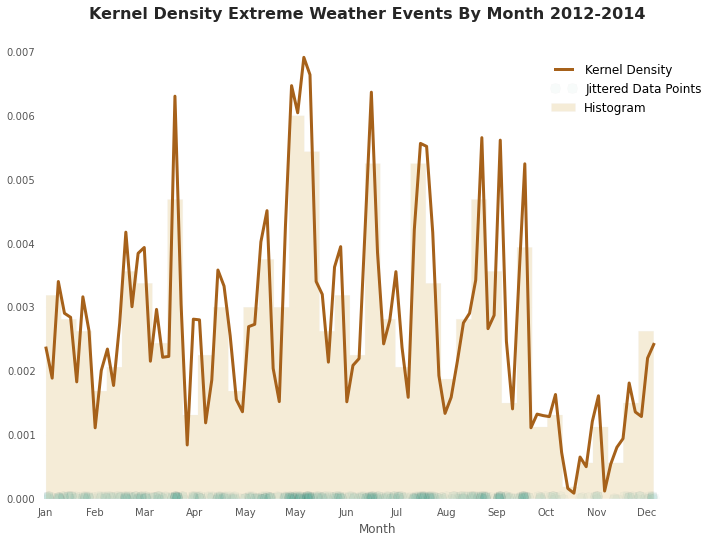

In [57]:
def convert_month(x):
    year = x.year - 2012
    month = month_days[x.month]
    day = x.day
    
    if x < date(2012, 2, 29):
        return month + day
    else:
        return 1 + month + day

    
daily_ext = prox[prox.extreme == 1][['date','extreme']]
dates_ext = daily_ext.date.apply(lambda x: convert_month(x))

fig = plt.figure(figsize = (12,8))
ax = plt.subplot(111)
plt.suptitle('Kernel Density Extreme Weather Events By Month 2012-2014',
             fontweight = 'bold', color = '#262626', fontsize = 16)

dates_ext = dates_ext.reshape(-1, 1)

kde = KernelDensity(bandwidth=2).fit(dates_ext)
x = np.linspace(dates_ext.min(), dates_ext.max(), 100).reshape(-1, 1)
density = np.exp(kde.score_samples(x))

plt.plot(x, density, linewidth = 3, label = 'Kernel Density', color = colors[0])
plt.hist(dates_ext, bins = 40, color = colors[1], normed = True, cumulative = False, 
     histtype = 'stepfilled', alpha = 0.30, label = 'Histogram')
plt.plot(dates_ext, abs(np.random.rand(len(dates_ext), 1)/20000), 'ok', \
         ms=10, alpha=.03, color = colors[3], label = 'Jittered Data Points')


plt.ylim(0, 0.007)
plt.xlabel('Month')
month_d={1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', \
         6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', \
         11:'Nov', 12:'Dec'}
xaxis = [month_d[(prox.date.min() + timedelta(days = i)).month] for i in np.arange(1,365,30)]
xvals = np.arange(1,365,30)
plt.xticks(xvals, xaxis, rotation = 0, fontsize = 10)


for label in ax.get_xticklines():
    label.set_visible(False)
for label2 in ax.get_yticklines():
    label2.set_visible(False)

ax.legend(loc = 'best')

plt.show()

## Based on the above plot, it appears extreme events are more common in the summer -- being in NY, intuition would suggest that the winter would have the bulk of the extreme weather events. It's possible that either this intuition is wrong, or that many of the stores are in warm-weather climates, e.g. the south.

In [58]:
def grid_kernel(sn):
    def convert_month(x):
        year = x.year - 2012
        month = month_days[x.month]
        day = x.day

        if x < date(2012, 2, 29):
            return month + day
        else:
            return 1 + month + day

    daily_ext = prox[np.logical_and(prox.extreme == 1, prox.station_nbr == sn)][['date','extreme']]
    dates_ext = daily_ext.date.apply(lambda x: convert_month(x))

    dates_ext = dates_ext.reshape(-1, 1)

    ax = plt.subplot(5, 4, sn)

    kde = KernelDensity(bandwidth=2).fit(dates_ext)
    x = np.linspace(dates_ext.min(), dates_ext.max(), 100).reshape(-1, 1)
    density = np.exp(kde.score_samples(x))

    plt.plot(x, density, linewidth = 3, label = 'Kernel Density', color = colors[0])
    # plt.hist(dates_ext, bins = 13, color = colors[1], normed = True, cumulative = False, 
    #      histtype = 'stepfilled', alpha = 0.30, label = 'Histogram')
    plt.plot(dates_ext, abs(np.random.rand(len(dates_ext), 1)/20000), 'ok', \
             ms=10, alpha=.03, color = colors[3], label = 'Jittered Data Points')

    ax.set_title('Station ' + str(sn))
    plt.ylim(0, density.max())
    plt.xlim([0, 365])

    if sn == 1:
        plt.xlabel('Month')
        plt.ylabel('Density')
        month_d={1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', \
                 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', \
                 11:'Nov', 12:'Dec'}
        xaxis = [month_d[(daily_ext.date.min() + timedelta(days = i)).month] for i in np.arange(0,365,45)]
        xvals = np.arange(0,365,45)
        plt.xticks(xvals, xaxis, rotation = 60, fontsize = 10)
    else:
        for label in ax.get_xticklabels():
            label.set_visible(False)
    for label in ax.get_yticklabels():
        label.set_visible(False)  
    
    for label in ax.get_xticklines():
        label.set_visible(False)
    for label2 in ax.get_yticklines():
        label2.set_visible(False)

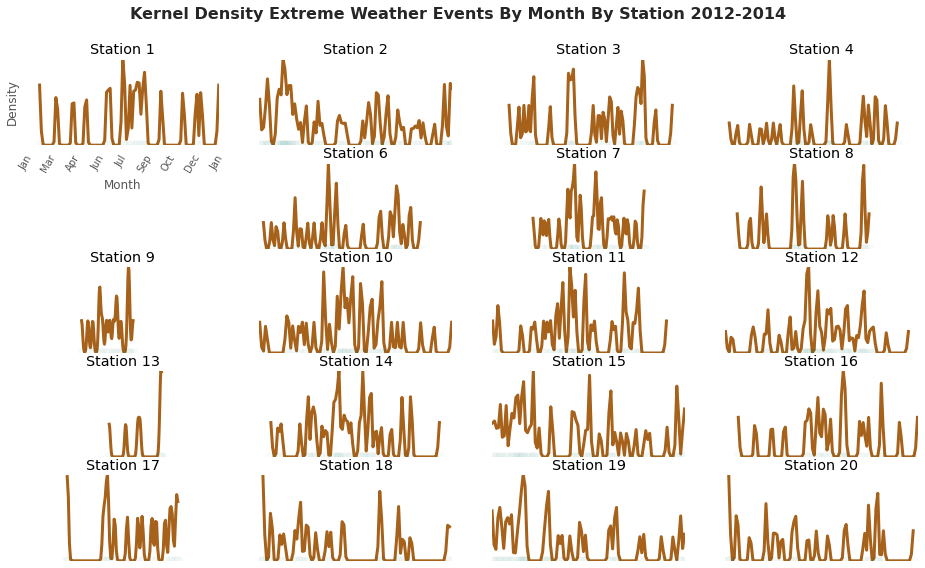

In [59]:
sn = 1
fig = plt.figure(figsize = (12,8))
plt.suptitle('Kernel Density Extreme Weather Events By Month By Station 2012-2014',
             fontweight = 'bold', color = '#262626', fontsize = 16)

for sn in np.arange(1, 21, 1):
    if sn != 5:
        grid_kernel(sn)

plt.show()

## We can see the distinct climates, e.g. Station 9 has only extreme weather events in the summer, whereas Station 2 has more extreme weather events in the winter.

# Now that we have prepared the weather data, we can join the stations with the corresponding stores.

In [60]:
all_train = train.merge(weather, on = ['station_nbr','date'])
all_test = test.merge(weather, on = ['station_nbr','date'])

In [61]:
item_sales = all_train[['units','item_nbr','store_nbr']]
days_with_sales = item_sales.copy()
days_with_sales.loc[:, 'units'] = days_with_sales.loc[:, 'units'].apply(lambda x: 1 if x > 0 else 0)

days_with_sales_possible = days_with_sales.groupby(['item_nbr','store_nbr']).count()
days_with_sales_possible.columns = ['days_possible']
days_with_sales = days_with_sales.groupby(['item_nbr', 'store_nbr']).sum()
days_with_sales.columns = ['days_w_sales']
total_sales = item_sales.groupby(['item_nbr', 'store_nbr']).sum()
total_sales.columns = ['total_sales']

### Our initial observation is that many of the store-item pairs have very few sales, while a few store-items comprise the bulk of the units sold.

The table below shows the number of days that store-item pair appeared in the training set, the number of days on which at least one unit was sold, and the total units sold.

In [62]:
sales = total_sales.merge(days_with_sales, left_index = True, right_index = True).\
        merge(days_with_sales_possible, left_index = True, right_index = True)

In [63]:
sales.loc[:, 'total_sales'] = (sales.loc[:, 'total_sales'].apply(lambda x: float(x)) / sales.loc[:, 'days_possible'])\
    .apply(lambda x: float(x))
sales.loc[:, 'days_w_sales'] = sales.loc[:, 'days_w_sales'].apply(lambda x: float(x)) / sales.loc[:, 'days_possible']\
    .apply(lambda x: float(x))    

In [64]:
def sales_bars(sales, name, sort = False):
    fig = plt.figure(figsize = (12, 8))
    
    for n in [1, 2]:
        ax = plt.subplot(2,1,n)

        x = np.arange(1,len(sales.index)+1,1)
        width = 0.75

        colors = brewer2mpl.get_map('BrBG', 'diverging', 4).mpl_colors

        if name == 'prop':
            
            bar = plt.plot(x, sales.iloc[:, 1], color = colors[3], label = 'Proportion Days w/ Sales')
            if n == 1:
                plt.ylabel('Proportion of Days by Item')
            plt.suptitle('Proportion Days w/ Sales', 
                         fontsize = 14, fontweight = 'bold', color = '#262626')
            plt.ylim(-0.01,1.01)
        else:
            bar2 = plt.plot(x, sales.iloc[:, 0], color = colors[0], label = 'Sales Per Day')
            if n == 1:
                plt.ylabel('Sales/Day')
            plt.suptitle('Sales Per Day by Item', 
                         fontsize = 14, fontweight = 'bold', color = '#262626')
            plt.ylim(-0.01,sales.iloc[:, 0].max()+1)

        for label in ax.get_xticklines():
            label.set_visible(False)

        for label in ax.get_yticklines():
            label.set_visible(False)
    
        if n == 1:
            plt.xlim(0,len(x))
            ax.set_title('All Items')
        else:
            plt.xlim(-0.05,300)
            ax.set_title('Top 250 Items')
            if sort == False:
                plt.xlabel('Item #')
            else:
                plt.xlabel('Rank')
        
        
        
        skip = 5

    plt.show()

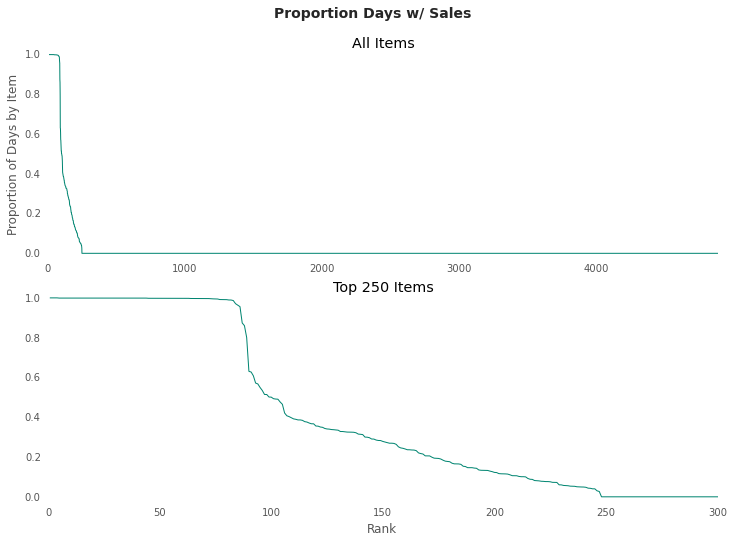

In [65]:
sales_bars(sales.sort('days_w_sales', ascending = False), 'prop', True)

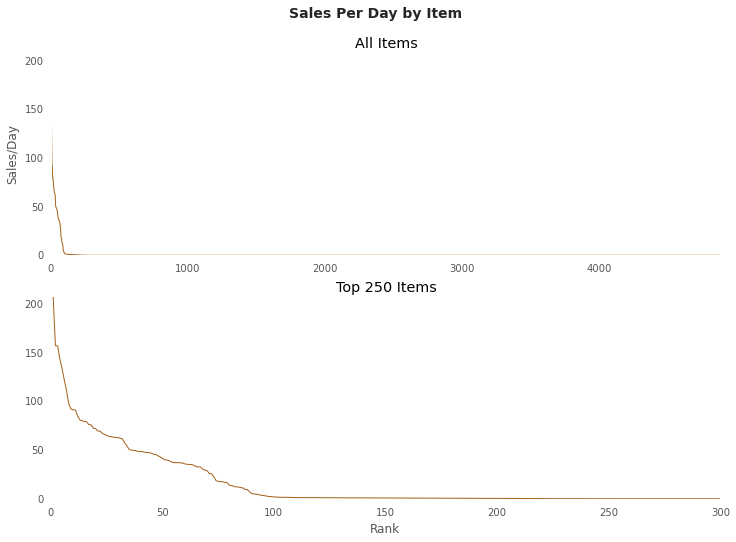

In [66]:
sales_bars(sales.sort('total_sales', ascending = False), 'total', True)

## We can see the long tail, with a few items making up most of the sales, both in terms of proportion of days with sales and total sales.

### Given the high proportion of store-items with 0 units sold, we will most likely predict 0 sales for the majority of items in the test set.

In [67]:
sales_all = all_train[['item_nbr','units','date']]

In [68]:
item_date_sales = sales_all.groupby(['item_nbr', 'date']).sum()

## Note: it seems a spike in sales is typically followed by a dip several says after... this makes sense, as the item may be out of stock and people have already purchased a surplus of that item.

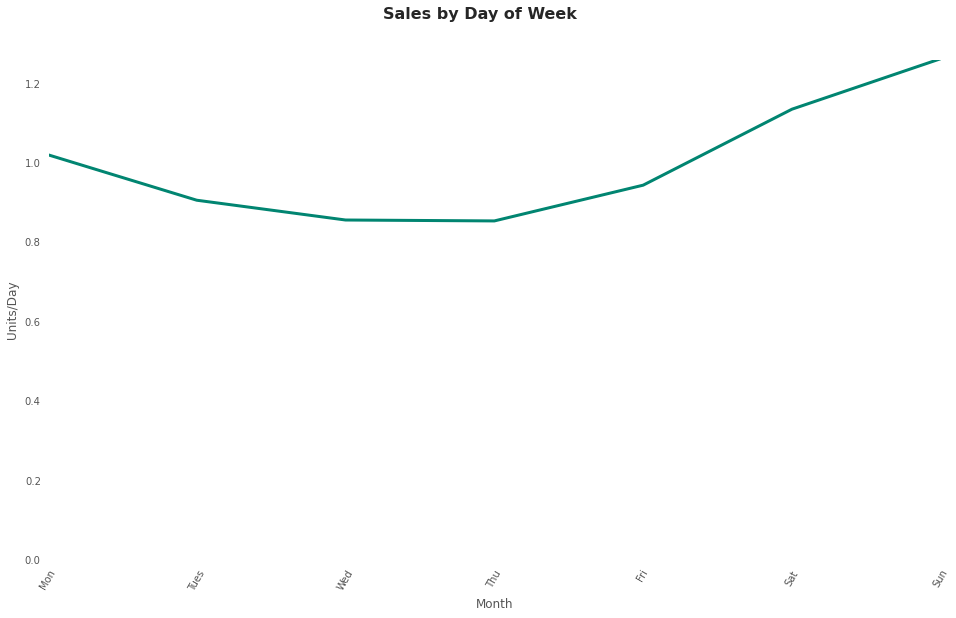

In [101]:
date_sales = sales_all[['units','date']]
date_sales.loc[:, 'date'] = date_sales.date.apply(lambda x: x.weekday()).values

date_sales = date_sales.groupby(['date']).mean()
date_sales['date'] = date_sales.index

daily_sales = date_sales.units.values
dates_sales = date_sales.date.values
# daily_ext = daily_ext.drop('idx', 1)

fig = plt.figure(figsize = (12,8))
ax = plt.subplot(111)
plt.suptitle('Sales by Day of Week',
             fontweight = 'bold', color = '#262626', fontsize = 16)

plt.plot(dates_sales, daily_sales, linewidth = 3, color = colors[3])

plt.ylim([0, max(daily_sales)])
plt.xlim([0, 6])

plt.xlabel('Month')
plt.ylabel("Units/Day")

month_d={ 0:'Mon', 1:'Tues', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun' }
xaxis = [month_d[i] for i in np.arange(0,7,1)]
xvals = np.arange(0,7,1)
plt.xticks(xvals, xaxis, rotation = 0, fontsize = 10)

for label in ax.get_xticklines():
    label.set_visible(False)
for label2 in ax.get_yticklines():
    label2.set_visible(False)

plt.show()

In [102]:
train_stormy = all_train[all_train.all_extreme > 0][['item_nbr','units','date']]
train_not = all_train[all_train.all_extreme == 0][['item_nbr','units','date']]

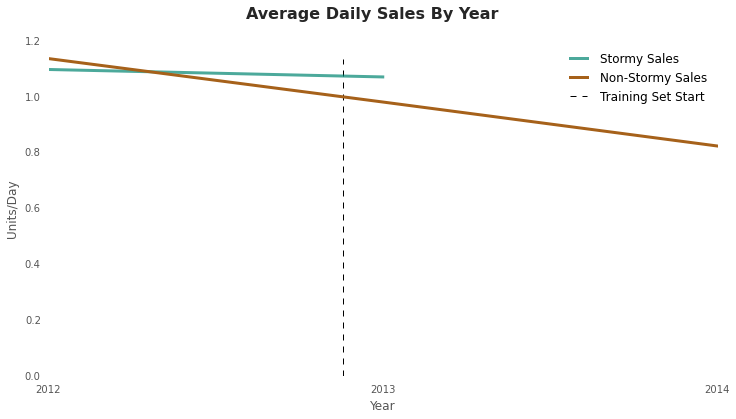

In [103]:
fig = plt.figure(figsize = (12,6))
ax = plt.subplot(111)
plt.suptitle('Average Daily Sales By Year',
             fontweight = 'bold', color = '#262626', fontsize = 16)

date_sales = train_stormy[['units','date']]
date_sales.loc[:, 'date'] = date_sales.date.apply(lambda x: x.year - 2012).values
date_sales = date_sales.groupby(['date']).mean()
date_sales['date'] = date_sales.index
plt.plot(date_sales.date.values, date_sales.units.values, linewidth = 3, alpha = 0.7, label = 'Stormy Sales', color = colors[3])

date_sales = train_not[['units','date']]
date_sales.loc[:, 'date'] = date_sales.date.apply(lambda x: x.year - 2012).values
date_sales = date_sales.groupby(['date']).mean()
date_sales['date'] = date_sales.index
plt.plot(date_sales.date.values, date_sales.units.values, linewidth = 3, label = 'Non-Stormy Sales', color = colors[0])

plt.vlines(456./1034.*2, 0, max(date_sales.units.values), linestyles = '--', label = 'Training Set Start')

# plt.ylim(0, 0.007)
plt.xlim([0, 2])

plt.xlabel('Year')
plt.ylabel("Units/Day")

plt.xticks([0, 1, 2], [2012, 2013, 2014], rotation = 0, fontsize = 10)

for label in ax.get_xticklines():
    label.set_visible(False)
for label2 in ax.get_yticklines():
    label2.set_visible(False)

ax.legend(loc = 'best')

plt.show()

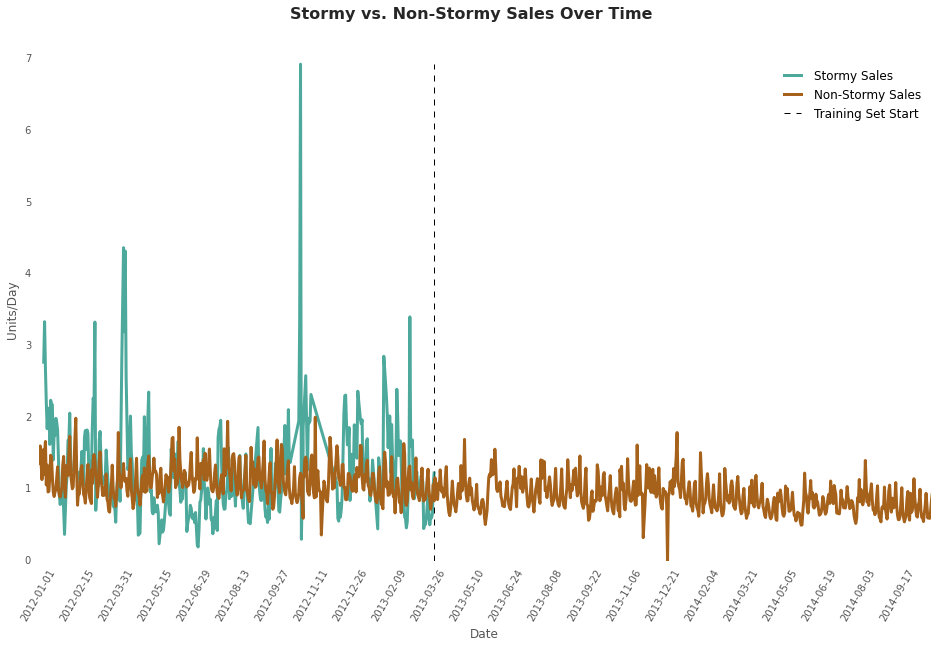

In [104]:
fig = plt.figure(figsize = (12,8))
ax = plt.subplot(111)
plt.suptitle('Stormy vs. Non-Stormy Sales Over Time', fontweight = 'bold', color = '#262626', fontsize = 16)

date_sales_s = train_stormy[['units','date']].groupby(['date']).mean()
date_sales_s['date'] = date_sales_s.index
daily_sales_s = date_sales_s.units.values
dates_sales_s = date_sales_s.date.apply(lambda x: convert_date(x)).values
plt.plot(dates_sales_s, daily_sales_s, linewidth = 3, alpha = 0.7, label = 'Stormy Sales', color = colors[3])

date_sales_n = train_not[['units','date']].groupby(['date']).mean()
date_sales_n['date'] = date_sales_n.index
daily_sales_n = date_sales_n.units.values
dates_sales_n = date_sales_n.date.apply(lambda x: convert_date(x)).values
plt.plot(dates_sales_n, daily_sales_n, linewidth = 3, label = 'Non-Stormy Sales', color = colors[0])

plt.vlines((test.date.min() - train.date.min()).days, 0, max(daily_sales_s), \
           linestyles = '--', label = 'Training Set Start')
plt.xlim([0, 1029])

plt.xlabel('Date')
plt.ylabel("Units/Day")

xaxis = [date_sales_n.date.min() + timedelta(days = i) for i in np.arange(0,1030,45)]
xvals = np.arange(0,1030,45)
plt.xticks(xvals, xaxis, rotation = 60, fontsize = 10)

for label in ax.get_xticklines():
    label.set_visible(False)
for label2 in ax.get_yticklines():
    label2.set_visible(False)

ax.legend(loc = 'best')
    
plt.show()

### Notice the spike during Sandy. We will look into this later, to see if we can learn from the fluctuations resulting from a major storm.

* #### Sandy hit NY/NJ on October 29. As seen in the tables below, there was a sales increase on October 27, and then the highest sales in the training set on October 28. Unsurprisingly, the sales the following 3 days were much lower, and then returned to roughly normal levels
* #### In March 2012 and again in April 2012, there was a tornado outbreak. 

In [105]:
date_sales_s = train_stormy[['units','date']].groupby(['date']).mean()

print date_sales_s.units.mean()
date_sales_s.sort('units', ascending = False).head(10)

1.24772899338


,units
date,
2012-10-28,6.918919
2012-04-07,4.360360
2012-04-09,4.315315
2012-04-06,3.567568
2013-03-03,3.396396
2012-01-07,3.328829
2012-03-05,3.324324
2012-10-27,3.315315
2012-04-08,3.189189


In [106]:
print 'Window around Sandy'
date_sales_s.loc[date(2012, 10, 26):date(2012, 11, 10), 'units']

Window around Sandy


date
2012-10-26    1.945946
2012-10-27    3.315315
2012-10-28    6.918919
2012-10-29    0.297297
2012-10-30    0.972973
2012-10-31    0.666667
2012-11-01    1.846847
2012-11-04    2.576577
2012-11-05    1.882883
2012-11-06    1.261261
2012-11-07    1.981982
2012-11-08    1.918919
2012-11-09    1.945946
2012-11-10    2.315315
Name: units, dtype: float64

In [107]:
train_stormy = all_train[all_train.all_extreme > 0][['date', 'store_nbr']].drop_duplicates()
train_not = all_train[all_train.all_extreme == 0][['date', 'store_nbr']].drop_duplicates()
test_stormy = test[['date', 'store_nbr']].drop_duplicates()
train_stormy.loc[:, 'date'] = train_stormy.loc[:, 'date'].apply(lambda x: date(x.year, x.month, 1))
train_not.loc[:, 'date'] = train_not.loc[:, 'date'].apply(lambda x: date(x.year, x.month, 1))
test_stormy.loc[:, 'date'] = test_stormy.loc[:, 'date'].apply(lambda x: date(x.year, x.month, 1))
train_stormy = train_stormy.groupby('date').count()
train_not = train_not.groupby('date').count()
test_stormy = test_stormy.groupby('date').count()

In [108]:
all_set_dates = list(train.date.apply(lambda x: date(x.year, x.month, 1)).unique())
all_test_dates = list(test.date.apply(lambda x: date(x.year, x.month, 1)).unique())
all_set_dates.extend(all_test_dates)
all_set_dates = list(set(all_set_dates))
storms = {}
for i in all_set_dates:
    storms[i] = []
    for df in [ train_stormy, train_not, test_stormy ]:
        if i in df.index:
            storms[i].append( df.loc[i, 'store_nbr'] )
        else:
            storms[i].append(0)

In [109]:
storms = DataFrame.from_dict(storms, orient = 'index')
storms.columns = 'train_stormy', 'train_not', 'test_stormy'
storms['total'] = storms[['train_stormy', 'train_not', 'test_stormy']].sum(axis = 1)
storms.sort_index(inplace = True)

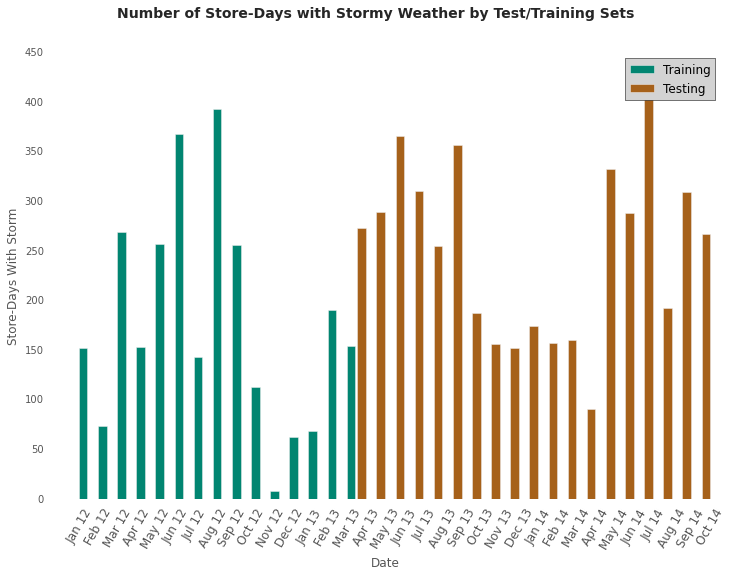

In [110]:
fig = plt.figure(figsize = (12, 8))
ax = plt.subplot(111)

x = np.arange(1,len(storms.index)+1,1)
width = 0.9

colors = brewer2mpl.get_map('BrBG', 'diverging', 4).mpl_colors

bar = plt.bar(x+width/2, storms.iloc[:, 0], width/2, color = colors[3], label = 'Training')
bar2 = plt.bar(x, storms.iloc[:, 2], width/2, color = colors[0], label = 'Testing')

for label in ax.get_xticklines():
    label.set_visible(False)

for label in ax.get_yticklines():
    label.set_visible(False)

plt.xticks(x+width/2,[i.strftime('%b %y') for i in storms.index], fontsize = 12, rotation = 60)
plt.xlabel('Date')
plt.ylabel('Store-Days With Storm')
plt.suptitle('Number of Store-Days with Stormy Weather by Test/Training Sets', 
             fontsize = 14, fontweight = 'bold', color = '#262626')
# x = plt.xlim([1, 21])

legend = ax.legend(loc = 'best')
legend = plt.legend(frameon = 2)
frame = legend.get_frame()
frame.set_color('lightgray')
frame.set_edgecolor('black') 

plt.show()

#### The training set stormy days and test set stormy days occurred in disjoint time periods, meaning we'll need to factor in time when creating our model.

### Let's investigate the Sandy spike and see if we can learn anything. The day before it hit NY/NJ was October 28, when we saw a huge spike:

#### 1 particular store-item had huge sales. Let's investigate this store-item in a $\pm$ 5 day window around the storm

In [116]:
curr_date = date(2012, 10, 28)
storm = all_train[np.logical_and(all_train.date >= curr_date - timedelta(days = 5), \
                        np.logical_and(all_train.date <= curr_date + timedelta(days = 5), \
                        np.logical_and(all_train.store_nbr == 16, \
                        all_train.item_nbr == 25)))]\
                        [['date','units','depart','preciptotal','resultspeed','avgspeed']]
# storm

#### It's hard to tell how high these are without context. Get the October monthly average for non-stormy days for each category and use those to normalize:

In [117]:
base = all_train[np.logical_and(all_train.all_extreme == 0, np.logical_and(all_train.date.apply(lambda x: x.month) == curr_date.month, \
                        np.logical_and(all_train.store_nbr == 16, all_train.item_nbr == 25)))]\
                        [['units','depart','preciptotal','resultspeed','avgspeed']]
baseline = {}
for c in base.columns:
    baseline[c] = base.loc[:, c].mean()
baseline = DataFrame.from_dict(baseline, orient = 'index')
baseline.columns = ['mean']
for c in storm.columns[1:]:
    storm.loc[:, c] = storm.loc[:, c].apply(lambda x: float(x) / baseline.loc[c, 'mean'])

#### The plot below shows the ratio of weather/sales relative to the date of the storm (dotted line).

#### Notice the spike in precipitation and wind speed the day of the storm, and the spike in sales the day $\textit{before}$ the storm.

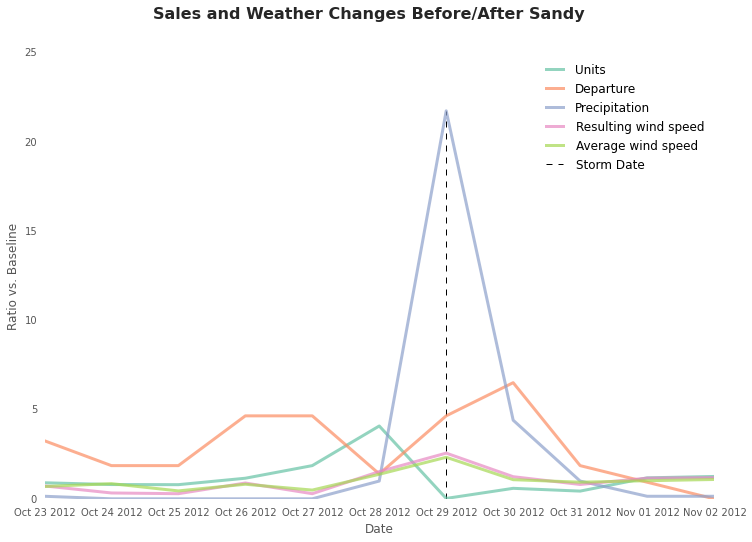

In [118]:
fig = plt.figure(figsize = (12, 8))
ax = plt.subplot(111)
plt.suptitle('Sales and Weather Changes Before/After Sandy',
             fontweight = 'bold', color = '#262626', fontsize = 16)

colors = brewer2mpl.get_map('Set2','qualitative',8).mpl_colors 
plt.plot(storm.date.values, storm.units.values, linewidth = 3, alpha = 0.7, label = 'Units', color = colors[0])
plt.plot(storm.date.values, storm.depart.values, linewidth = 3, alpha = 0.7, label = 'Departure', color = colors[1])
plt.plot(storm.date.values, storm.preciptotal.values, linewidth = 3, alpha = 0.7, label = 'Precipitation', color = colors[2])
plt.plot(storm.date.values, storm.resultspeed.values, linewidth = 3, alpha = 0.7, label = 'Resulting wind speed', color = colors[3])
plt.plot(storm.date.values, storm.avgspeed.values, linewidth = 3, alpha = 0.7, label = 'Average wind speed', color = colors[4])
plt.vlines(date(2012, 10, 29), 0, max(storm.preciptotal.values), linestyles = '--', label = 'Storm Date')

plt.xlabel('Date')
plt.ylabel("Ratio vs. Baseline")

for label in ax.get_xticklines():
    label.set_visible(False)
for label2 in ax.get_yticklines():
    label2.set_visible(False)

ax.legend(loc = 'best')

plt.show()

#### There is a big spike in units sold the day before the actual storm. We can see precipitation and wind speeds spike during the storm itself. It makes sense intuitively that people will purchase many items before the storm in preparation. We can use the days relative to the storm as a feature in our model. 

## Modeling Objective

The model objective is to predict units sold to reduce the Root Mean Squared Log Error:

 $$RMSLE =\sqrt{\frac{1}{n} \sum_{i=1}^n (\log(p_i + 1) - \log(a_i+1))^2 }$$, where $p_i$ is the prediction for the i-th store-item sale, and $a_i$ is the actual number of units sold. This is cleary a regression task. As a baseline, we will predict using averages over the data. We will then model using regularized linear regression and random forest regression. Since 97% of units sold are zero and most variables in the problem are categorical, we will see that linear regression does not perform well; a decision-tree based regression is a more natural contender.

### Caveats

It is important to note that we are only predicting units sold for stormy days (extreme periods), defined as $\pm 3$ days from an actual storm (extreme day). An extreme day is defined as having greater than 1 inch of rain or 2 inches of snow. We thus split the weather features into extreme and not extreme weather periods. It is also important to note that item numbers are not persistent for each store. In other words, **each store has different items corresponding to each item number**.

### Building Features

We build weather features using the cleaned weather data. Firstly, we binarize the textual codesums into 22 categories. The codesums are descriptive binary variables referring to the nature of a storm that occurs on a particular day [1]. For example, "RA" would indicate rain and "SN+" would indicate heavy snow. Some days have multiple codesums.

We also add two date-based features to capture seasonal variations, since we saw from the visualizations that sales spiked on weekends and during certain months:
* `day_of_week`: An integer from 1-7 indicating the day of the week
* `month`: An integer from 1-12 indicating the month

Next, we merge 15 codesums that showed little information gain from tree based modeling into 3 combined features [2]. We do this by using Singular Value Decomposition, to transform fifteen columns of features into just three [3]. They are labeled as `codesum_combined_i` where $i \in \{1,2,3\}$. The codesums that weren't combined with SVD are `RA`, `SN`, `SG`, `GS`, and `TS`, which correspond to rain, snow, snow grains, small hail, and thunderstorm.

In order to capture purchases for items in anticipation of a storm or after a storm, we create two features:
* `after_storm_intensity`: An integer value of 1,2, or 3 indicating the number of days after a storm.
* `before_storm_intensity`: An integer value of 1,2, or 3 indicating the number of days before a storm.
If certain days fall between multiple storms, a sum total is taken of intensity features.

We also cluster other high dimensional features such as `tavg`, `preciptotal`, `stnpressure`, `resultspeed`, `avgspeed`, `wetbulb` into 3-4 clusters using KMeans [3]. The weather cluster of an extreme day is inserted as a feature 3 days before and 3 days after a particular storm.
* `weather_cluster_after`: the weather cluster of a storm imputed in all 3 days after a storm
* `weather_cluster_before`: 3 days before a storm

In [72]:
features = read_csv('../data/weather_features02.csv', index_col = 'Unnamed: 0')
train = read_csv('../data/train_c.csv', index_col = 'Unnamed: 0')
test = read_csv('../data/test_c.csv', index_col = 'Unnamed: 0')
key = read_csv('../data/key.csv')

In [73]:
features = pp.binarize_codesums(features)                            # binarize codesums
features, features_not_extreme = pp.extreme_weather_split(features)  # split features into extreme/not-extreme 
features = pp.date_features(features)                                # date features
features = pp.storm_intensity_features(features)                     # storm intensity 
features = pp.merge_unwanted_codesums(features)                      # SVD on codesums
features = pp.cluster_weather_lags(features, k=4)                    # propagate weather clusters +/- 3 days

### Merge features with train/test

We merge all the weather features just created with both our stormy and not stormy train/test sets. 

In [ ]:
train, test, train_o, test_o = pp.merge_features(train, test, features, key)
train_not_extreme, test_not_extreme = pp.merge_not_extreme_features(train_o, test_o, features_not_extreme, key)

### Get not stormy sales aggregated by store, item, and 1 month periods
 
As an added feature, we create `sales_by_store_item_month_not_extreme`, which is an average of a store-item-month_year for non-stormy periods. Since stormy periods are very sparse, we find this feature to be very predictive of units sold during stormy periods. One-month aggregates are used since any finer date selection yields missing values for some items. Using `sales_by_store_item_month_not_extreme` over the whole train set already yields a low RMSLE of 0.1309, which is plotted below.

In [ ]:
train, test = pp.get_sales_by_store_item_month_not_extreme(\
                train, test, train_not_extreme, test_not_extreme)
print rmsle(train.units, train.sales_by_store_item_month_not_extreme)

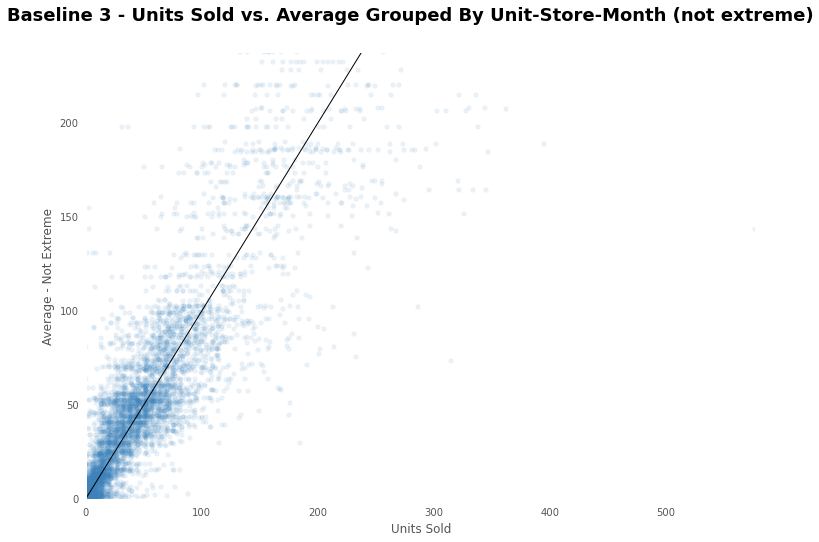

In [124]:
fig = plt.figure(figsize = (12,8))
ax = plt.subplot(111)

colors = brewer2mpl.get_map('Set1', 'qualitative', 4).mpl_colors

plt.scatter(train.loc[:, 'units'], train.loc[:, 'sales_by_store_item_month_not_extreme'], \
            color = colors[1], alpha = 0.1)
identity_line = np.linspace(max(min(train.units.values), min(train.sales_by_store_item_month_not_extreme.values)),
                            min(max(train.units.values), max(train.sales_by_store_item_month_not_extreme.values)))
plt.plot(identity_line, identity_line, color="black", linestyle="-", linewidth=1.0)


plt.ylabel('Average - Not Extreme')
plt.xlabel('Units Sold')
plt.suptitle('Baseline 3 - Units Sold vs. Average Grouped By Unit-Store-Month (not extreme)', 
             fontsize = 18, fontweight = 'bold')

for label in ax.get_xticklines():
    label.set_visible(False)
for label in ax.get_yticklines():
    label.set_visible(False)

plt.xlim([train.units.min(),train.units.max()])
plt.ylim([train.sales_by_store_item_month_not_extreme.min(),train.sales_by_store_item_month_not_extreme.max()])

plt.show()

### Modeling

Throughout the model selection process, we use k-fold cross validation with 5 folds over the training set. Kaggle withholds 30% of the test set for the leaderboard, and uses the final 70% for evaluation once the competition is over. Since the 30% test-set withheld from Kaggle is randomly shuffled, we also use a random shuffle in our k-fold cross validation.

In [ ]:
kf = KFold(train.shape[0], n_folds=5, shuffle = True)

In [138]:
m.all_zeros_benchmark(train, kf)

Baseline-1: All Zeros Benchmark
	 Average error:  0.53671084279
	 Standard Deviation:  0.00728333036969


##### Baseline-2
    The simplest thing we could do, apart from the all-zeros benchmark, is to average the units sold per store and item, and then make a prediction.  We call this model Baseline-2. A visualization of the predictions over the entire test set is shown. A submission to Kaggle yields an RMSLE of 0.20398. Relative changes in our cross-validation error are used as a global metric for model selection.

In [71]:
test_pred_baseline2 = m.baseline2(train, test, kf)
# plot_sales(test_pred, True)
# 0.20398 on Kaggle

NameError: name 'kf' is not defined

#### Baseline-3
    The next simplest thing we could do is to make a prediction based on units sold in not-stormy periods for the same store, item, and month, which was exactly the `sales_by_store_item_month_not_extreme` feature created earlier. We call this model Baseline-3. A submission to Kaggle yields an RMSLE of 0.10613, which is our best submission as of yet. 

In [129]:
m.baseline3(train, test, kf)
pred_test_baseline3 = test.sales_by_store_item_month_not_extreme
# 0.10613 on Kaggle

Baseline3: Using not stormy sales as a prediction for stormy sales:
	 Average error:  0.130839573924
	 Standard Deviation:  0.00404291961162
Creating submission file 'submission_simple_average2.csv'


To improve Baseline-3, we want to capture the large deviations from normal sales due to stormy weather, which is shown in the plot below.

In [130]:
# plt.plot(train.units - train.sales_by_store_item_month_not_extreme,'.')
# print rmsle(train.units, train.sales_by_store_item_month_not_extreme)
print 'Average difference in sales: ',np.average(train.units - train.sales_by_store_item_month_not_extreme)
print 'Standard Deviation: ', np.std(train.units - train.sales_by_store_item_month_not_extreme)

Average difference in sales:  -0.00679493360779
Standard Deviation:  3.88838895774


#### Linear Models
The first step in modeling would be to try a simple linear regression, as shown in class. 

Average error:  0.134124057697
Standard deviation:  0.00363627764098
Creating submission file 'submission_ols2.csv'


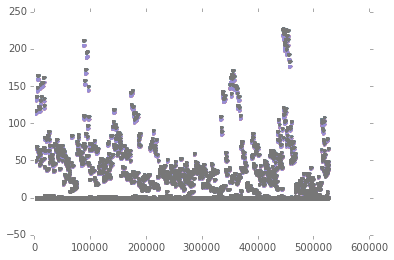

In [139]:
alpha = [.01, .1, 1, 10, 100]
fit_vars = ['sales_by_store_item_month_not_extreme', 'before_storm_intensity', 'after_storm_intensity',\
           'tavg', \
           'preciptotal']
pred = m.linear_model(train, test, kf, alpha, fit_vars)
plt.plot(pred,'.')
plt.plot(test.sales_by_store_item_month_not_extreme,'.')
# 0.11163 on Kaggle

The objective function for Lasso regression is: 
$$Loss = \frac{1}{2n_{samples}}  ||y - Xw||^2_2 + \alpha ||w||_1$$, where $X$ is the data and $y$ are the units sold. 
Different sets of features were experimented with to reduce cross-validation error, but we were not able to get Lasso to perform better than Baseline-3. Using a linear model does not deviate its prediction much from Baseline-3, since the linear model is not capturing much information from the features, many of which are categorical. In addition, there is a large class imbalance since units sold with 0 values are dominated by 97% of the data. The linear model deviations from Baseline-3 makes the test error go up, indicating that deviations are not made in the right direction!

#### Random Forest Regression

To improve our score from the Baseline-3, we need to capture the change in sales due to weather events. This may be captured with a decision-tree type of regressor since the sales of an item is not easily represented as a linear function of its inputs; we assume that certain storm features should trigger nonlinear surges in sales for certain items. We can imagine constructing several "conditional statements" to predict how much a particular item should deviate from the norm. This is exactly what a decision tree does.

We can reproduce the Baseline-2 with a decision tree based method as shown below. However, note that we shouldn't actually be using `item_nbr` as a feature due to the caveats of this feature explained earlier. 

	 Feature importance:
	 	store_nbr 	0.70778817692
	 	item_nbr 	0.29221182308
	 Average error:  0.148824599359
	 Std:  0.00425313041353


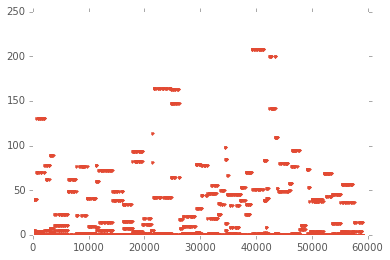

In [140]:
fit_vars = [ 'store_nbr', 'item_nbr']
pred_rf1 = m.random_forest_1(train, test, kf, fit_vars)
# 0.20375 on Kaggle

Next, we add our not_stormy sales feature, since this achieves our best prediction in Baseline-3. We can also add more categorical variables and start to evaluate the feature performance using Information Criterion [2]. Features were selected greedily based on feature importances to reduce local cross validation error [2]. Our local RMSLE is reduced to 0.138, which is an improvement over Baseline-2, but worse than Baseline-3. This is further validated through a submission to Kaggle yielding an RMSLE of 0.12689, which is slightly worse than Baseline-3. Note that predicted sales over test look more natural compared to Baseline-3. We are also able to reduce the variance of predicted sales from actual sales.

In [141]:
fit_vars = ['sales_by_store_item_month_not_extreme',  'before_storm_intensity',\
            'after_storm_intensity','tavg', 'weather_cluster_before', 'weather_cluster_after',\
           'codesum_combined_1', 'codesum_combined_2']
pred_rf2 = m.random_forest_1(train, test, kf, fit_vars)

	 Feature importance:
	 	sales_by_store_item_month_not_extreme 	0.908145127487
	 	tavg 	0.0422681462763
	 	before_storm_intensity 	0.0124235481025
	 	after_storm_intensity 	0.0115627132443
	 	codesum_combined_2 	0.00916762236963
	 	codesum_combined_1 	0.00704748345044
	 	weather_cluster_before 	0.00533698036055
	 	weather_cluster_after 	0.00404837870876
	 Average error:  0.141556271114
	 Std:  0.00425035281326


In [142]:
pred_train = m.random_forest_1(train, test, kf, fit_vars, submission=True)
# Kaggle test set error: 0.12689

Creating submission file 'submission_rf11.csv'


In [143]:
# plt.plot(pred_train - train.units, '.')
print '\t Average difference in sales: ', np.average(pred_train-train.units)
print '\t Standard deviation: ', np.std(pred_train-train.units)

	 Average difference in sales:  0.00582948281326
	 Standard deviation:  1.44943365874


Although we are able to reduce the variance for the difference of not stormy and stormy sales, our cross-validated error still did worse than Baseline-3. It may be the case that we are just modeling "noise" instead of capturing actual weather effects. How can we both reduce the cross-validated error while capturing weather effects in sales? 

We first propose a "divide and conquer" approach, where we train one RF model for each store. Interactions between each store are sacrificed here, although there may not have been much to gain since each store has different item numbers. 

As a benchmark to improve this model, we train just on `sales_by_store_item_month_not_extreme`, and later add more features greedily using feature importances [2].

In [144]:
fit_vars = ['sales_by_store_item_month_not_extreme']
_ = m.random_forest_by_store(train, test, kf, fit_vars)

	 Average error: 0.135306569581
	 Std: 0.00340257971802
	 Feature importance: 
	 	sales_by_store_item_month_not_extreme 	1.0
	 	store_nbr 	0.0


In [145]:
fit_vars = ['sales_by_store_item_month_not_extreme',  'before_storm_intensity', 'after_storm_intensity',\
           'tavg', 'weather_cluster_before', 'weather_cluster_after','preciptotal',\
           'codesum_combined_1', 'codesum_combined_2', 'month', 'day_of_week', 'item_nbr']
_ = m.random_forest_by_store(train, test, kf, fit_vars)

	 Average error: 0.135323801664
	 Std: 0.00312387017329
	 Feature importance: 
	 	sales_by_store_item_month_not_extreme 	0.599526696521
	 	day_of_week 	0.0982340689023
	 	tavg 	0.0719024913039
	 	preciptotal 	0.0561482381732
	 	after_storm_intensity 	0.0559716991861
	 	weather_cluster_after 	0.0526481614473
	 	item_nbr 	0.0144421052493
	 	month 	0.0135988026819
	 	codesum_combined_2 	0.0110234026938
	 	weather_cluster_before 	0.0099470681846
	 	before_storm_intensity 	0.00914469964804
	 	codesum_combined_1 	0.00741256600853
	 	store_nbr 	0.0


In [146]:
m.random_forest_by_store(train, test, kf, fit_vars, submission=True)
# 0.13046 on Kaggle

[0.065394511566494229]
	 Average error: 0.0653945115665
	 Std: 0.017524683969
	 Average difference in sales:  0.00470010062714
	 Standard deviation:  1.31074487558
Creating submission file 'submission_rf12.csv'


#### More approaches tried:

Training an RF for each store did not help in reducing corss-validation error. Several other models were tried:

1. Predict the deviations from Baseline-3 only on items with high deviations, and add those predictions back to Baseline-3.
2. Do a group-by on deviations from units sold from Baseline-3, and add those back to Baseline-3.
3. Subset the items with highest error from Baseline-3 and model those separately. For the rest of the items, use Baseline-3 as the predictions.

#### What this problem boils down to:

If we want to improve the model from Baseline-3, it is helpful to look at the deviations from Baseline-3 predictions. For items with deviations above a certain threshold, we call these items `stormy_items`, and we add this binary variable as a new feature. Only 3-5% of items fall into this category.

Percent deviated using threshold =  20  
  0.560056107254  %


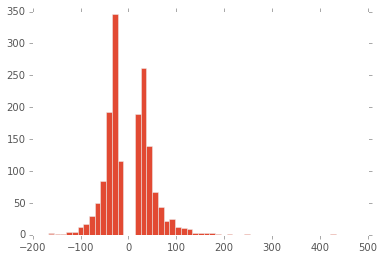

In [147]:
train, test = pp.stormy_item(train, test, thresh = 20)
train_stormy_items = train.loc[train.stormy_item == True]
test_stormy_items  = test.loc[test.stormy_item == True]

We believe that modeling `stormy_items` separately from other items is the best approach moving forward (approach 3). The reason being, a majority of the error in our model comes from these `stormy_items`, giving an RMSLE of 0.656. The rest of the data is very well modeled using Baseline-3, giving an RMSLE of 0.047. If we can somehow model these items separately, we may be able to improve our score.

In [148]:
rmsle(train_stormy_items.units, train_stormy_items.sales_by_store_item_month_not_extreme)

0.65622679880320811

In [149]:
rmsle(train[train.stormy_item == False].units, train[train.stormy_item == False].sales_by_store_item_month_not_extreme)

0.047048109893436753

In [150]:
kf_stormy = KFold(train_stormy_items.shape[0], n_folds=5, shuffle = True)
fit_vars = ['sales_by_store_item_month_not_extreme', 'before_storm_intensity', 'after_storm_intensity',\
           'weather_cluster_before', 'weather_cluster_after','day_of_week', 'store_nbr']
pred = m.random_forest_1(train_stormy_items, test_stormy_items, kf_stormy, fit_vars)

	 Feature importance:
	 	sales_by_store_item_month_not_extreme 	0.870213695005
	 	day_of_week 	0.0460343320391
	 	store_nbr 	0.0304901386794
	 	before_storm_intensity 	0.0187384322563
	 	after_storm_intensity 	0.0155638346856
	 	weather_cluster_before 	0.0110040522179
	 	weather_cluster_after 	0.00795551511717
	 Average error:  0.704003044678
	 Std:  0.0146205821837


# Conclusion

Our best model so far was Baseline-3, a simple group-by and average over stores, items, and month_year ids. The challenge in modeling sales is a huge class imbalance for type of items being sold. Only about 3 items per store seem like they are weather sensitive. It has proven difficult to extract valuable information from the weather features to make a predictive model on stormy units. We believe that the best approach moving forward is to use a separate curated model for stormy items, and use Baseline-3 predictions for the rest. **As of May 8, 2015, our submission on Kaggle ranked in the top 17% of contenders.**

## Life Lessons learned
*  Read the directions before jumping into modeling.
* Explore and understand the data before jumping into modeling.
*  Model the simplest, dumbest thing first and explore more complex alternatives if those fail.

# References

1. Quality Controlled Climalogical Data. 2015-05-01. URL https://goo.gl/F3shxE
2. L. Breiman, (2001). Random Forests, Machine Learning, 45(1), 5-32.
3. Golub, G.H. & Reinsch, C. (1970). Singular value decomposition and least squares solutions. Numerische Mathematik, 14, 403-420.